# Chapter 7 回帰分析の悩みどころ

## 7.1 交互作用

交互作用とは、回帰分析において説明変数同士の掛け算などの項を考慮すること。

例えば5.1節のモデルに説明変数の交互作用の項を追加すると、
$$
\begin{align}
&\mu[n] = b_1 + b_2 A[n] + b_3 Score[n] &n = 1, \ldots, N \nonumber \\
&\text{に交互作用の項を追加} \nonumber \\
&\mu[n] = b_1 + b_2 A[n] + b_3 Score[n] + b_4A[n]Score[n] &n = 1, \ldots, N \nonumber \\
&\text{式変形すると} \nonumber \\
&\mu[n] = b_1 + b_2 A[n] + (b_3 + b_4A[n]) Score[n] &n = 1, \ldots, N \nonumber \\
\end{align}
$$
となる。アルバイトが好きかどうか$A[n]$によって、$Score$が増えた時の傾きが変わることになる。この交互作用の解釈は一般的にはかなり複雑になるため、重回帰では交互作用を考慮しない倍が多い。(前もって交互作用を確認できている場合、交互作用を知ることが目的の場合を除く)

また、説明変数$A[n]$のかわりに4つのクラブへの所属状況$c_j[n] \ j=1, \ldots, 4$を考える場合。交互作用の項は以下になる。
$$
(b_3 + b_4 C_1[n] + b_5 C_2[n] + b_6 C_3[n] + b_7 C_4[n])Score[n]
$$
このとき、サンプル数の少ないクラブに掛かっている係数$b$は推定に失敗する。そこで$b_4 \sim b_7$は類似しているというゆるい制約を入れる方法がある。8章の階層モデルで説明。

## 7.2 対数を取るか否か

対数によって変数変換すると解釈がしやすいケースがある。例えば変数の対数を取ってから回帰を行うなど手法が当てはめられる。

対数を取ると、説明変数と応答変数の関係が何倍という物差しで解釈できる。

以下に関東近辺の架空の賃貸物件のデータ(data-rental.txt)について、横軸に部屋の広さ、縦軸に2年間のトータル費用をとって散布図にしたものを示す。左は非対数、右は両対数グラフ。

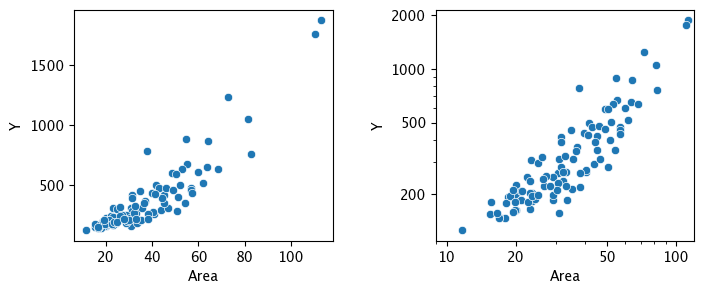

In [1]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

rental = pl.read_csv("chap07/input/data-rental.txt")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
sns.scatterplot(rental, x="Area", y="Y", ax=ax1)
plt.setp(ax1, xticks=np.arange(20, 120, 20), yticks=np.arange(500, 2000, 500))
sns.scatterplot(rental, x="Area", y="Y", ax=ax2)
xticks = (1, 2, 5, 10, 20, 50, 100)
yticks = (200, 500, 1000, 2000)
plt.setp(
    ax2,
    xscale="log",
    yscale="log",
    xticks=xticks,
    xticklabels=xticks,
    yticks=yticks,
    yticklabels=yticks,
    xlim=(9, 120),
)
plt.show()

下記の二通りのモデルで単回帰してみる。

- Nは物件数
- nは物件のインデックス

モデル式 7-1 ([model7-1.stan](chap07/model/model7-1.stan))
$$
\begin{align}
&\mu[n] = b_1 + b_2 Area[n] &n=1, \ldots, N \nonumber \\
&Y[n] \sim \text{Normal }(\mu[n], \sigma_Y) &n=1, \ldots, N \nonumber
\end{align}
$$

非対数のグラフに直線を当てはめて、正規分布に従うノイズを仮定したモデル。

モデル式 7-2 ([model7-2.stan](chap07/model/model7-2.stan))
$$
\begin{align}
&\mu[n] = b_1 + b_2 \log_{10} (Area[n]) &n=1, \ldots, N \nonumber \\
&log_{10}(Y[n]) \sim \text{Normal }(\mu[n], \sigma_Y) &n=1, \ldots, N \nonumber
\end{align}
$$

両対数のグラフに直線を当てはめて正規分布に従うノイズを仮定したモデル。

両モデルをStanで実装し、推定を行い、次に、
- 予測分布
- 実測値と予測値のプロット
- 推定されたノイズの分布

を確認する

In [43]:
"""推定"""

import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
import seaborn as sns


rental = pl.read_csv("chap07/input/data-rental.txt")

N_new = 50
Area_new = np.linspace(10, 120, N_new)
data = {
    "N": rental.shape[0],
    "Area": rental["Area"].to_list(),
    "Y": rental["Y"].to_list(),
    "N_new": N_new,
    "Area_new": Area_new,
}
sm = sm = CmdStanModel(
    stan_file="chap07/model/model7-1.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit1 = sm.sample(data=data, seed=1234)

data.update(
    {
        "Area": rental["Area"].log10().to_list(),
        "Y": rental["Y"].log10().to_list(),
        "Area_new": np.log10(Area_new),
    }
)
sm = sm = CmdStanModel(
    stan_file="chap07/model/model7-2.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit2 = sm.sample(data=data, seed=1234)

19:20:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:20:16 - cmdstanpy - INFO - CmdStan done processing.


19:20:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:20:17 - cmdstanpy - INFO - CmdStan done processing.
19:20:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-2.stan', line 23, column 4 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-2.stan', line 23, column 4 to column 30)
Consider re-running with show_console=True if the above output is unclear!


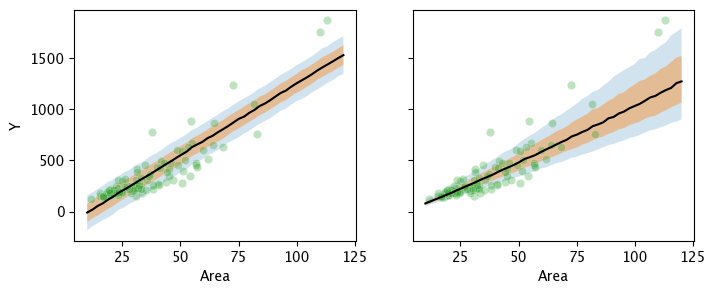

In [45]:
"""予測分布"""


def calc_quantiles(y_pred: np.ndarray, prob: list[int]) -> pl.DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


ms1 = {
    "y_pred": fit1.y_pred,
    "y_new": fit1.y_new,
}

ms2 = {
    "y_pred": np.power(10, fit2.y_pred),
    "y_new": np.power(10, fit2.y_new),
}
_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for ms, ax in zip([ms1, ms2], axes):
    d_est = calc_quantiles(ms["y_new"], [10, 25, 50, 75, 90])
    ax.fill_between(Area_new, d_est["p10"], d_est["p90"], alpha=0.2)
    ax.fill_between(Area_new, d_est["p25"], d_est["p75"], alpha=0.4)
    ax.plot(Area_new, d_est["p50"], color="k")
    sns.scatterplot(rental, x="Area", y="Y", ax=ax, alpha=0.3)
plt.show()

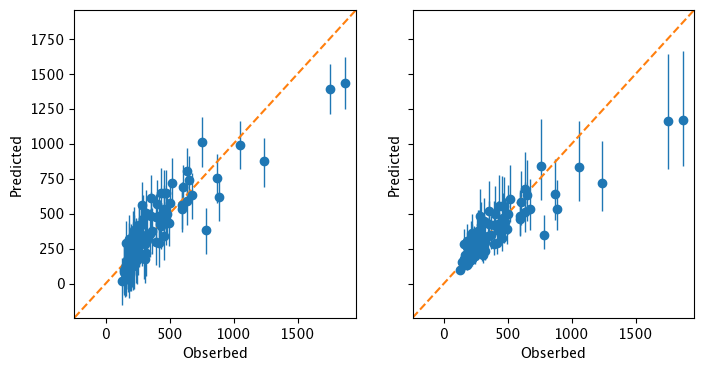

In [18]:
"""実測値と予測値のプロット"""

_, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for ms, ax in zip([ms1, ms2], axes):
    d_est = calc_quantiles(ms["y_pred"], [10, 50, 90])
    ax.errorbar(
        rental["Y"],
        d_est["p50"],
        yerr=[d_est["p50"] - d_est["p10"], d_est["p90"] - d_est["p50"]],
        fmt="o",
        elinewidth=1,
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = (min(xmin, ymin), max(xmax, ymax))
    ax.plot(lim, lim, linestyle="dashed")
    plt.setp(ax, xlim=lim, ylim=lim, xlabel="Obserbed", ylabel="Predicted")
plt.show()

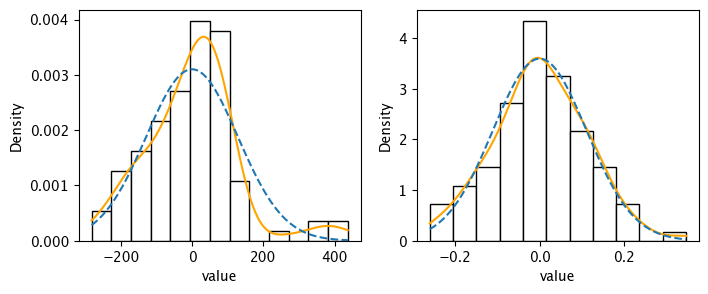

In [40]:
"""推定されたノイズの分布"""
from scipy import stats


def calc_MCMC_noise(Y: pl.Series, mu: np.ndarray) -> pl.DataFrame:
    return pl.DataFrame(
        Y.to_numpy() - mu, schema=["noise{}".format(i) for i in range(Y.shape[0])]
    )


N_mcmc1 = fit1.method_variables()["lp__"].size
N_mcmc2 = fit2.method_variables()["lp__"].size
d_noise1 = calc_MCMC_noise(rental["Y"], fit1.mu)
d_noise2 = calc_MCMC_noise(rental["Y"].log10(), fit2.mu)


def get_map(col):
    kernel = stats.gaussian_kde(col)
    dens_x = np.linspace(min(col), max(col), kernel.n)
    dens_y = kernel.pdf(dens_x)
    mode_x = dens_x[np.argmax(dens_y)]
    mode_y = dens_y[np.argmax(dens_y)]
    return (mode_x, mode_y)


d_mode1 = d_noise1.transpose().apply(get_map)
d_mode1.columns = ["X", "Y"]
d_mode2 = d_noise2.transpose().apply(get_map)
d_mode2.columns = ["X", "Y"]

s_MAP1 = pl.DataFrame([get_map(fit1.s_Y)], schema=["X", "Y"])
s_MAP2 = pl.DataFrame([get_map(fit2.s_Y)], schema=["X", "Y"])

_, axes = plt.subplots(1, 2, figsize=(8, 3))
for d_mode, s_MAP, ax in zip([d_mode1, d_mode2], [s_MAP1, s_MAP2], axes):
    sns.histplot(
        d_mode["X"],
        ax=ax,
        kde=True,
        stat="density",
        color="orange",
        facecolor="w",
    )
    xdata = ax.lines[0].get_xdata()
    ax.plot(xdata, stats.norm.pdf(xdata, scale=s_MAP["X"]), linestyle="dashed")
    plt.setp(ax, xlabel="value")

plt.show()

これらの図から非対数の数値の場合は、
- 80%ベイズ予測区間が負の値を合む(予測分布。実測値-予測値のプロット)
- 広くて費用が高い物件(Areaがおよそ70m$^2$以上の物件)に結果が引きずられてノイズの分布が歪んでおり、正規分布と乖離がある(推定されたノイズの分布のプロット)
  
  この原因は、家賃が高いほどばらつきが大きくなり、非対数のモデルではそれがそのまま反映されるからである。Areaが100m$^2$より大きい数個の点を除くだけで推定結果が大きく変わってしまうだろう。この状況は頑健性が低いと言えるのでなるべく避けたい。

対数をとって、回帰を行うことでこれらの問題が改善されているが、実測値-予測値のプロットではAreaが大きいほど80%信頼区間も広くなっている。このように非対数と対数のどちらが正しいとは言えず、あくまで今回はそういう仮定をしたにすぎない。

他に指数関数で増えるような現象のメカニズムが背景にあると考えられる場合は対数を取る。複利・細胞分裂など。

## 7.3 非線形の関係

データによっては非線形な曲線を当てはめて回帰を行いたい場合がある。

- 二次曲線の例
  
  ある家庭における夏から冬にかけての一日あたりのエアコン消費電力$Y(kWh)$と、屋外での平均気温$X(℃)$ (data-aircon.txt)

このデータの散布図を見てみれば曲線で回帰できる事がわかるが、ここにどのような曲線を当てはめるべきか。本来はメカニズムから考えるが、それが不明な場合もある。その場合はなるべくシンプルで解釈し易い曲線を当てはめるのがよい。つまりここでは二次曲線となる。モデルとしては、この家庭が「快適と感じる温度$x_0$」に対して、消費電力$Y$は$(X - x_0)^2$に従って増えると仮定する。

モデル式 7-3 ([model7-3.stan](chap07/model/model7-3.stan))

$$
Y[n] \sim \text{Normal }\left(a + b (X[n] - x_0)^2, \sigma_Y \right) \qquad n = 1, \ldots, N
$$

散布図と回帰曲線のプロットを以下で行う

In [42]:
"""推定"""
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel


aircon = pl.read_csv("chap07/input/data-aircon.txt")

N_new = 60
X_new = np.linspace(-3, 32, N_new)
data = {
    "N": aircon.shape[0],
    "X": aircon["X"].to_list(),
    "Y": aircon["Y"].to_list(),
    "N_new": N_new,
    "X_new": X_new,
}
sm = sm = CmdStanModel(
    stan_file="chap07/model/model7-3.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=1234)

19:18:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:18:50 - cmdstanpy - INFO - CmdStan done processing.


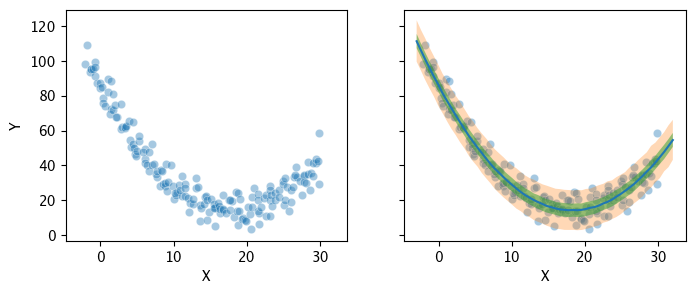

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns


def calc_quantiles(y_pred: np.ndarray, prob: list[int | float]) -> pl.DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for ax in axes:
    sns.scatterplot(aircon, x="X", y="Y", ax=ax, alpha=0.4)
d_est = calc_quantiles(fit.y_new, [2.5, 25, 50, 75, 97.5])
axes[-1].fill_between(X_new, d_est["p2.5"], d_est["p97.5"], alpha=0.3)
axes[-1].fill_between(X_new, d_est["p25"], d_est["p75"], alpha=0.5)
axes[-1].plot(X_new, d_est["p50"])
plt.show()

- 時系列データの例
  
  患者に点滴を投与する。投与からの経過時間$Time(hour)$とくすりの血中濃度$Y(mg/mL)$のデータ(data-conc.txt)に対して回帰を行う。

この現象の背景には微分方程式に従う物理法則$y = a \{1 - \exp(-bt) \}$があると考えられている[<sup>3)</sup>](#fn3)。a,bは曲線の形を決めるパラメータ。tは経過時間。この曲線はt=0のときy=0である。

モデル式 7-4 ([model7-4.stan](chap07/model/model7-4.stan))

$$
Y[t] \sim \text{Normal }(a \{1 - \exp(-b Time[t]) \}, \sigma_Y) \quad t = 1, \ldots, T
$$

- $T$: 測定したタイミングの数
- $t$: Tのインデックス
- $Time[t]$: 測定時の経過時間
- $\sigma_Y$: 観測誤差を含むノイズの大きさ

以上をもとに、データから$a, b, \sigma_Y$を推定する。

> [<sup id="fn3">3)</sup>](#fn3-back) 以下のパラメータを考える。
> - $t$: 経過時間
> - $y$: 血中濃度
> - $A$: 血中への単位時間あたりの薬剤流入量($A \gt 0$)
> - 薬剤が体内で分解される速度は血中濃度に比例すると考えられているので$-by$とおく
> 
> これらをまとめて微分方程式で書くと
> $$
> \frac{dy}{dt} = A - by \\
> $$
> ここで$A=b \times a$と置けるとすると
> 
> $$
> \frac{dy}{dt} = b(a - y)
> $$
> 
> となり解は、
> 
> $$
> y = a \{1 - C_0 \exp(-bt) \}
> $$
> 
> ここで、$t=0の時、y=0$という条件から定数$C_0 = 1$


In [1]:
"""エアコンデータの折れ線グラフと回帰曲線"""
import numpy as np
import polars as pl
from cmdstanpy import CmdStanModel


conc = pl.read_csv("chap07/input/data-conc.txt")

# 推定
T_new = 60
Time_new = np.linspace(-0, 24, T_new)
data = {
    "T": conc.shape[0],
    "Time": conc["Time"].to_list(),
    "Y": conc["Y"].to_list(),
    "T_new": T_new,
    "Time_new": Time_new,
}
sm = sm = CmdStanModel(
    stan_file="chap07/model/model7-4.stan", cpp_options={"STAN_THREADS": "TRUE"}
)
fit = sm.sample(data=data, seed=123)

/Users/sean/Documents/myscript/python-bayes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
20:50:02 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-4.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-4
20:50:07 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-4
20:50:07 - cmdstanpy - WARNING - Stan compiler has produced 4 warnings:
20:50:07 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-4.hpp /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap07/model/model7-4.stan
Warn


20:50:08 - cmdstanpy - INFO - CmdStan done processing.
20:50:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


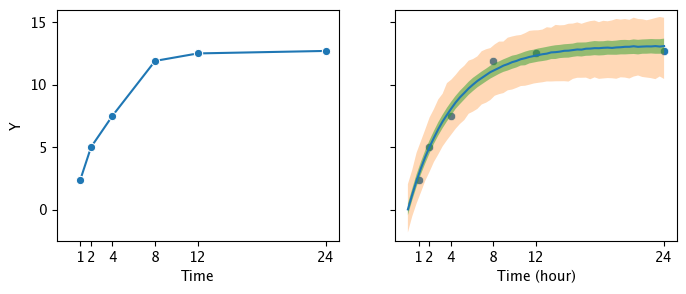

In [5]:
# グラフ描画
from matplotlib import pyplot as plt
import seaborn as sns


def calc_quantiles(y_pred: np.ndarray, prob: list[int | float]) -> pl.DataFrame:
    d_est = pl.DataFrame(
        np.percentile(y_pred, prob, axis=0).T, schema=[f"p{p}" for p in prob]
    )
    return d_est


d_est = calc_quantiles(fit.y_new, [2.5, 25, 50, 75, 97.5])
_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
sns.lineplot(conc, x="Time", y="Y", marker="o", ax=axes[0])
sns.scatterplot(conc, x="Time", y="Y", ax=axes[1])
axes[1].fill_between(Time_new, d_est["p2.5"], d_est["p97.5"], alpha=0.3)
axes[1].fill_between(Time_new, d_est["p25"], d_est["p75"], alpha=0.5)
axes[1].plot(Time_new, d_est["p50"])
plt.setp(
    axes[1],
    xlabel="Time (hour)",
    ylabel="Y",
    xticks=conc["Time"],
    yticks=np.arange(0, 16, 5),
    ylim=(-2.5, 16),
)
plt.show()

このように時系列データには非線形関数の応用例が多い。例えば、振り子の振動の幅(空気抵抗などの影響で指数関数で減少)など。

他のよく知られている非線形関数の例
1. $y = C_0 \exp(-bt)$ 振り子の振幅[<sup>4)</sup>](#fn4)
2. $y = C_0 / \{1 + a \exp(-bt) \}$ S字型に増加する
3. $y = C_0 \{ \exp(-b_2t) - \exp(-b_1t) \}$ ある時点から減少する[<sup>5)</sup>](#fn5)

![Alt text](chap07/output/fig7-7.png)

> [<sup id="f4">4)</sup>](#fn4-back) この現象の背後には、常微分方程式で書くと、$dy / dt = -by$ (ただし$b > 0$)という関係があると考えられる。

> [<sup id="fn5">5)</sup>](#fn5-back) 前者は$dy/dt = -py^2 + qy$ (ただし$p, q \gt 0$で、$p, q$と$a,b,C_0$の間には関係式がある)という常微分方程式の解である。後者は以下の連立常微分方程式の解($y_2$の時間変化)である。
> $$
> \begin{cases}
>     dy_1 / dt = -b_1 y_1 \\
>     dy_2 / dt = -b_1 y_1 -b_2 y_2
> \end{cases}
> ただし(b_1 \gt b_2 \gt 0)
> $$
